# Functions


`Function` class objects provide the building blocks for mathematical expression within Underworld2. The primary aim of this class is to enable a natural description of mathematics through the Python syntax so that users may quickly and accurately prototype model behaviour. 

Functions are used extensively across the Underworld2 API and provide a unified interface to Underworld2 discrete objects (`SwarmVariable` and `MeshVariable` objects). 

The user is encouraged to drill down interactively into the function submodules to discover 
available functionality, or alternatively browse the API reference
reference at the [underworld documentation site](https://underworld2.readthedocs.io).

**Overview:**

1. A simple example. 
1. Usage basics.
1. Module overview.
1. The `evaluate()` method.
1. The `input` function.
1. Branching functions.

**Keywords:** functions, swarms, meshvariables, materials


## A Simple Example

Let us define a function which we might use as a variable heat conductivity for a thermal problem. It will take the following temperature dependent form:

$$
    k(\mathbf{x}) = 5 +8\exp({5T(\mathbf{x})})
$$


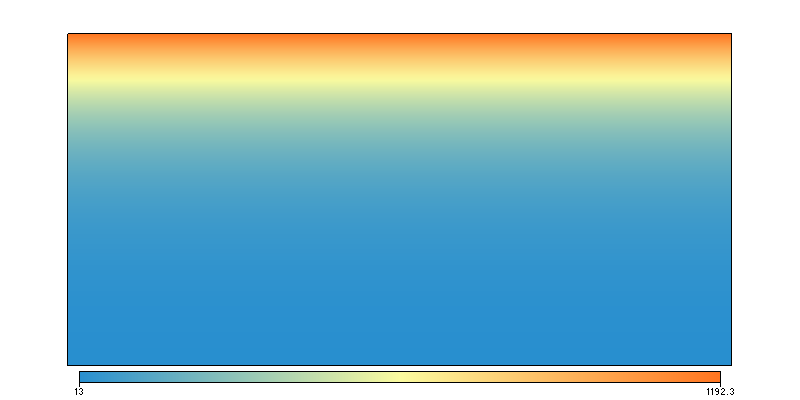

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer

# first create a mesh and variable
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))
tempVar = mesh.add_variable(1)
# init the temp variable 
for index,coord in enumerate(mesh.data):
    tempVar.data[index] = coord[1]
    
# and now define the function.
fn_k = 5. + 8.*fn.math.exp(5.*tempVar)            # a

# vis
fig = glucifer.Figure(figsize=(800,400))
fig.append(glucifer.objects.Surface(mesh,fn_k))   # b
fig.show()                                        # c

Let's deconstruct the `Function` defined at step (a) above:

```
fn_k = 5.                              # 1
          + 8.*                        # 2
               fn.math.exp(            # 3
                            5.*temp )  # 4
```

Things to note at the positions above:

1. You can directly use Python native numerical objects. Under the hood, the native Python float object created here '`5.`' will be automatically converted to an Underworld2 `Constant` type function. Note that arithmetic operations only currently support float type objects, and an exception will be thrown for other types. For this reason, you often need to be careful where you use Python natives (for instance, using '`5`' here instead of '`5.`' would result in an error). 
1. Again, the native '`8.`' will be automatically converted. The addition operator here will be automatically converted to an Underworld `Addition` operation through operator overloading. Likewise for the multiplication operation. 
1. Note that for an exponential function, we need to use the Underworld provided `fn.math.exp` function, **not** the Python `math` module `exp` function. 
1. Here the argument (`5.*temp`) is itself a `Function`, and `Function` compounding applies. Importantly, note that the `MeshVariable` is used directly in the arithmetic, and this is possible because it is also a `Function` class object (more on this soon). 

At step (b), we provide the function to the visualisation object (`Surface`). `Function` objects are expected in many places across the Underworld2 API. Finally, at step (c), the actually function evaluation occurs, though under the hood it is a two step process. In the first step, tests are performed to ensure that the provided function is compatible with the required operation. Compatibility is dependent on a number of factors which we discuss below ('Conformal input & output checking'), and if there are any problems an exception will be raised here to notify the user. The second step is the required function evaluation, and will generally be the most compuationally expensive phase.

## Usage basics

### Underworld data objects
As seen in the example above, Underworld data objects (`MeshVariable` and `SwarmVariable` types) may be used directly within functions, as they are indeed themselves `Function` objects (via Python multiple inheritance). The Function class provides a uniform interface to these objects and is (largely) agnostic to the underlying data discretisation, instead providing mechanisms for evaluation at arbitrary coordinates. Note that true arbitrary coordinate evaluation is not possible for `SwarmVariable` objects, as they are purely discrete and do not (currently) have supporting interpolation functions. The _special case_ inputs provided by objects of the `FunctionInput` class may be used for `SwarmVariable` objects (more on this soon). 

The following simple example demonstrates querying a `MeshVariable` object.

In [2]:
import underworld as uw
from underworld import function as fn

mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))
sinvar = mesh.add_variable(1)

# initialise with a sine perturbation
import numpy as np
sinvar.data[:,0] = np.sin( np.pi*mesh.data[:,0] )

# use the `evaluate()` method to perform query.. more on this below 
result = sinvar.evaluate( (0.25,0.) ) 
print("Evaluation result: {}".format(result))

import math
if not np.allclose( result, math.sqrt(2.)/2. ):
    raise RuntimeError("Error! Expected result was not obtained.")

Evaluation result: [[ 0.70710678]]


### Elementary algebraic operations
Use the Python equivalents (`+`,`-`,`*`,`/`) directly with your `Function` objects! `Function` objects are operator overloaded to facilitate this. Note however that only functions which return floating point type values are compatible with elementary operations currently, and an exception will be raised otherwise.

Let's have a play with some mesh variables initialised to constants.

In [3]:
import underworld as uw
from underworld import function as fn
import numpy as np
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))

# create some more mesh variables and initialise
two_var = mesh.add_variable(1)
six_var = mesh.add_variable(1)
two_var.data[:] = 2.
six_var.data[:] = 6.

# create some functions via the Python operators
fn_plus  = two_var + six_var
fn_minus = two_var - six_var
fn_div   = two_var / six_var
fn_times = two_var * six_var

# check results.. evaluate anywhere as our mesh variables are constant
coord = (0.1234, 0.5678)
resultplus  =  fn_plus.evaluate( coord )
resultminus = fn_minus.evaluate( coord )
resultdiv   =   fn_div.evaluate( coord )
resulttimes = fn_times.evaluate( coord )

print("Addition result      : {}".format(resultplus))
print("Subtraction result   : {}".format(resultminus))
print("Division result      : {}".format(resultdiv))
print("Multiplication result: {}".format(resulttimes))

# run tests
if not ( np.allclose(resultplus,  8.)    and
         np.allclose(resultminus,-4.)    and
         np.allclose(resultdiv,   1./3.) and 
         np.allclose(resulttimes, 12.)   ):
    raise RuntimeError("Error! Expected result was not obtained.")

Addition result      : [[ 8.]]
Subtraction result   : [[-4.]]
Division result      : [[ 0.33333333]]
Multiplication result: [[ 12.]]


## Convenience conversions

Python elementary types (int/floats/etc) may be used directly with Underworld Function objects in algebraic operations. Likewise, Python tuples (or lists) of Underworld Functions are automatically converted into `Function` objects which return vector results composed of the tuple/list entries. It is often important to remember that the elementary algebraic operations are only compatible with float type objects, and therefore you will often need to write '`5.`' (which will be converted to a double precision float object) instead of '`5`' (which will be converted to a integer object). 

Note that conversions can only occur automatically where the Python object (tuple or primary math object) comes _in contact_ with an Underworld function, whereby conversion occurs by virtue of the object overloading. However, occasionally we may wish to explicitly perform conversions, generally where we wish to use the `evaluate()` method or when we wish to utilise overloading. The `convert()` static method on the `Function` class provides this functionality.

In [4]:
import underworld as uw
from underworld import function as fn
import numpy as np
import math
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))

# create a new mesh variable and initialise
cosvar = mesh.add_variable(1)
cosvar.data[:,0] = np.cos( np.pi*mesh.data[:,0] )
sinvar = mesh.add_variable(1)
sinvar.data[:,0] = np.sin( np.pi*mesh.data[:,0] )

# create function. note that `2.` and the `1.` are automatically converted
sin2 = 2.*sinvar*cosvar + 1.

# evaluate somewhere and then test
import random
coord = ( random.random(), 0. )
result = sin2.evaluate(coord)
expected = math.sin(2.*math.pi*coord[0]) + 1.  # via double angle formula
if not np.allclose(result, expected, rtol=5e-2, atol=5e-2):
    print(coord, expected, result)
    raise RuntimeError("Error! Expected result was not obtained.")
# also let's create a vector function on the fly.
# first create a vector mesh variable
vecvar = mesh.add_variable(2)
vecvar.data[:] = (1.,1.)

# now the function definition, evaluation, and test
fn_vec = vecvar + (sinvar, cosvar)
result = fn_vec.evaluate(coord)
expected = (math.sin(math.pi*coord[0]) + 1., math.cos(math.pi*coord[0]) + 1.)
if not np.allclose(result, expected, rtol=5e-2, atol=5e-2):
    print(result, expected)
    raise RuntimeError("Error! Expected result was not obtained.")

# now let's create a Python tuple from UW functions. 
vec_as_py_tuple = (sinvar, cosvar)
print("`vec_as_py_tuple` type is: {}".format(type(vec_as_py_tuple)))

# The following will not work! This is because it is still a Python
# native `tuple` object, and as such does not have an `evaluate()` method.
# vec_as_py_tuple.evaluate()  

# However, we can convert it to a UW function, and then use `evaulate()`.
vec_as_uw_fn = fn.Function.convert(vec_as_py_tuple)
print("`vec_as_uw_fn` type is: {}".format(type(vec_as_uw_fn)))

# this is better
print("evaluate: {}".format(vec_as_uw_fn.evaluate(coord)))

`vec_as_py_tuple` type is: <type 'tuple'>
`vec_as_uw_fn` type is: <class 'underworld.function._function.add'>
evaluate: [[ 0.91933336  0.39229551]]


## Basic mathematical functions
Basic functions (such as `sin()` and `exp()`) are provided by the `underworld.function.math` module. Note that the Python `math` module is **not** compatible with Underworld2 functions (you must use _our_ math module). Operator overloads are also provided from the indexing operator (`[]`) and the power operator (`**`).

We will construct some more double angle formula here. While in the previous example, we used Numpy to initialise a mesh variable object to construct `sin` and `cos` like functions, here all mathematical operations will be performed by Underworld `Function` objects. 

In [5]:
import underworld as uw
from underworld import function as fn
import random
import numpy as np
import math

# trig funcs
sin = fn.math.sin()
cos = fn.math.cos()
tan = fn.math.tan()

# double angle formula
sin_2theta = 2.*sin*cos
cos_2theta = 1. - 2.*sin**2
tan_2theta = (2.*tan)/(1.-tan**2)

# get somewhere to evaluate
theta = random.random()

# do things check out? 
if not ( np.allclose( sin_2theta.evaluate(theta), math.sin(2*theta) )    and
         np.allclose( cos_2theta.evaluate(theta), math.cos(2*theta) )    and
         np.allclose( tan_2theta.evaluate(theta), math.tan(2*theta) ) ):
    raise RuntimeError("Error! Expected result was not obtained.")

## Relational and logical functions
Relational functions are constructed via the Python relational operators (`<`,`<=`,`>`,`>=`). Underworld functions for `AND`, `OR` and `XOR` logical operations are also available, and these overload the Python bitwise operators (`&`,`|`,`^`) (though they do **not** perform bitwise operations). These functions will all return boolean results.


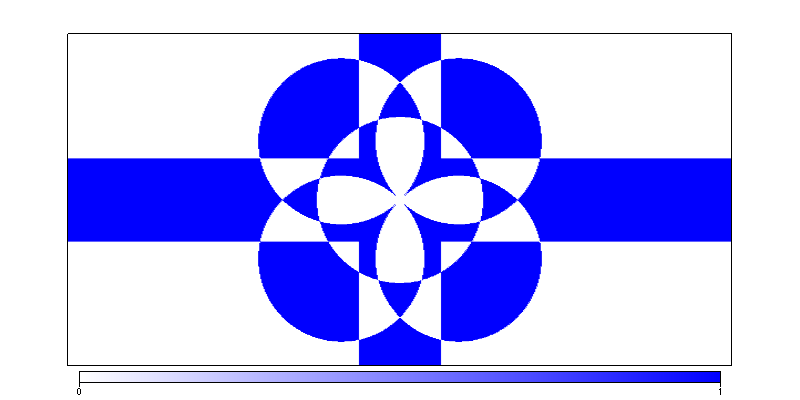

In [6]:
import underworld as uw
from underworld import function as fn
import numpy as np
import math
import glucifer
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))

# define a logical function for inside a unit circle.
# we will use the `input()` function as a proxy for the coordinate (see below).
radius = 1.
coord = fn.input()
inside_circle = ( coord[0]**2 + coord[1]**2 < radius**2 )

# test at some locations
if not ( np.allclose( inside_circle.evaluate( (0. ,0. ) ), True  )    and
         np.allclose( inside_circle.evaluate( (1. ,1. ) ), False )    and
         np.allclose( inside_circle.evaluate( (0.5,0.5) ), True  )    and
         np.allclose( inside_circle.evaluate( (0.9,0.5) ), False ) ):
    raise RuntimeError("Error! Expected result was not obtained.")

# now something a bit more complex.. first, some circles
radius = 0.25
offset = (1.0,0.5)
deltax = radius*math.cos(math.pi/4.)
deltay = radius*math.sin(math.pi/4.)
coord1 = fn.input() - offset 
circle1 = ( fn.math.dot(coord1,coord1) < radius**2 )
coord2 = coord1 - ( deltax, deltay)
circle2 = ( fn.math.dot(coord2,coord2) < radius**2 )
coord3 = coord1 - (-deltax, deltay)
circle3 = ( fn.math.dot(coord3,coord3) < radius**2 )
coord4 = coord1 - ( deltax,-deltay)
circle4 = ( fn.math.dot(coord4,coord4) < radius**2 )
coord5 = coord1 - (-deltax,-deltay)
circle5 = ( fn.math.dot(coord5,coord5) < radius**2 )

# now create a cross.. note the use of the OR operator
cross =  ( (fn.math.abs(coord1[0])<radius/2.) | (fn.math.abs(coord1[1])<radius/2.) )

# visualise the XOR of these shapes
fig = glucifer.Figure(figsize=(800,400))
fig.append(glucifer.objects.Surface(mesh, circle1^circle2^circle3^circle4^circle5^cross, resolution=600, onMesh=False, colours=['white','blue']))
fig.show()

## Conformal input & output checking
When you define your functions, they are input agnostic in the sense that you describe your function without declaring the type of argument that will be used when the function is eventually evaluated. At evaluation time, checks are performed to ensure the argument is compatible with the provided function. Likewise, the output returned by the evaluated function will be checked to ensure it is of the required form. If a check fails, an exception is thrown.

### Incompatible function input
The example below demonstrates an incompatible input type. We will use the `tempVar` object, and attempt to evaluate it with a scalar input. This is not a valid operation, as `tempVar` is a `MeshVariable` type object and therefore can only be successfully evaluated at a valid domain coordinate, and therefore requires a vector input (the coordinate!). We will also use the `min()` function to set a lower bound (of zero) on the function's returned results.

In [7]:
import underworld as uw
from underworld import function as fn
mesh = uw.mesh.FeMesh_Cartesian()
tempVar = mesh.add_variable(1)

positiveTemp = fn.misc.min(0.,tempVar)
try:
    positiveTemp.evaluate((0.1,))
except RuntimeError as e:
    print("RuntimeError: "+str(e))

RuntimeError: Issue utilising function of class 'MeshVariable' constructed at:
    Line 4 of notebook cell 7:
       tempVar = mesh.add_variable(1)

Error message:
Function input dimensionality (1) does not appear to match mesh variable dimensionality (2).


Let's deconstruct this error message. The second part specifies the actual problem that was encountered, in this case the input being a scalar where a vector was required. The first part tells you where the function that cannot be evaluated was defined. This is useful information because often you will define a function in a very different place to where you will eventually evaluate it. More importantly, complex functions are usually defined through numerous Python calls (as in this case where we introduce `min()`), so we try to flag to you the actual subfunction that was problematic (in this case `tempVar`, not `min`).

Functions can of course only be evaluated at a point within their domain. So for `MeshVariable` objects, you may only evaluate at a coordinate within the mesh domain. Furthermore, in parallel, you may only evaluate within the mesh domain local to the process:

In [8]:
# note that this cell requires you to run the previous cell first
try:
    positiveTemp.evaluate((-1.0,1.0))  # but the failure will occur at evaluation time.
except ValueError as e:
    print("RuntimeError: "+str(e))

RuntimeError: Issue utilising function of class 'MeshVariable' constructed at:
    Line 4 of notebook cell 7:
       tempVar = mesh.add_variable(1)

Error message:
FeVariable interpolation at location (-1, 1) does not appear to be valid.
Location is probably outside local domain.


`SwarmVariable` objects are purely discrete (they do not carry interpolation functions as do their `MeshVariable` counterpart), so their domain is the set of all particles coordinates. As such, an arbitrary coordinate cannot be used as an input. However due to algorithmic considerations, it is also **not** possible to feed in the coordinate of a particle for evaluation, and instead you must use the special `FunctionInput` class for evaluations, which we will explore shortly. 

In [9]:
import underworld as uw
from underworld import function as fn
mesh = uw.mesh.FeMesh_Cartesian()
swarm = uw.swarm.Swarm(mesh)
svar = swarm.add_variable('double',1)
swarm.populate_using_layout(uw.swarm.layouts.PerCellSpaceFillerLayout(swarm,1))

try:
    svar.evaluate((0.2,0.3))
except RuntimeError as e:
    print("RuntimeError: "+str(e))

RuntimeError: Issue utilising function of class 'SwarmVariable' constructed at:
    Line 5 of notebook cell 9:
       svar = swarm.add_variable('double',1)

Error message:
Unable to evaluate function using provided input. 
Note that your function is constructed using a SwarmVariable. We do not 
currently support interpolation of SwarmVariables, so where you wish to 
`evaluate()` a SwarmVariable based function, you may only do so using 
the swarm itself as the input to the function evaluation, resulting in 
evaluation at each particle location. Note also that for evaluation, 
you must use the Swarm object from which the SwarmVariable was derived. 
Alternatively, you may wish to project your function onto a MeshVariable 
(using a MeshVariable_Projection object) and then perform interpolation 
on the MeshVariable object.


### Incompatible function output

All functions require inputs of a certain form, and also return results of a (generally different) form. The object that is performing the evaluation then utilises these outputs for its given task. In the following example, we are trying to visualise a function using the `Surface` visualisation object. This object generates a raster image representing the provided function, with a single colour mapped to a given scalar function result. As such, while the function is successfully evaluated in the following, it returns a vector result where a scalar is required.

In [10]:
# the `Surface` object can only visualise scalar objects
import underworld as uw
from underworld import function as fn
import glucifer

mesh = uw.mesh.FeMesh_Cartesian()
vecvar = mesh.add_variable(2)

fig = glucifer.Figure()
try:
    fig.append(glucifer.objects.Surface(mesh,vecvar))  # failure will occur here
except RuntimeError as e:
    print("RuntimeError: "+str(e))

RuntimeError: Provided function must return a scalar result.


## Function are dynamic

Functions are dynamic in the sense that they **do not** capture a static representation of their constituent functions at definition time, but instead simply refer to these functions at evaluation time. This means that if any of the constituent functions change (such as when you update your velocity field), these changes are reflected immediately:

In [11]:
import underworld as uw
from underworld import function as fn
mesh = uw.mesh.FeMesh_Cartesian()
# create mesh var and init to 1.
meshvar = mesh.add_variable(1)
meshvar.data[:] = 1.

# now create a function which utilises the mesh var and evaluate
evaluation_coord = (0.1,0.2)
fn_test = meshvar * 5.
result_before = fn_test.evaluate(evaluation_coord) 

# now modify the meshvar and evaluate the fn again
meshvar.data[:] = -1.
result_after = fn_test.evaluate(evaluation_coord) 

print(result_before,result_after)

(array([[ 5.]]), array([[-5.]]))


## The `evaluate()` Method


Once you have created functions, you will pass these into various objects within the Underworld2 API, however you will often also wish to directly evaluate the functions you have created for analytic or testing purposes. The `evaluate()` method provides this capability. Here are some basic examples using the function created previously:

In [12]:
import underworld as uw
from underworld import function as fn
coord = fn.input()  # more on the input function soon
fn_k = 5. + 8.*fn.math.exp(5.*coord[1])    

# evaluate at single location, provide as a coordinate tuple or list.
result = fn_k.evaluate( (0.3,0.2) )
print( "Single evaluation result = \n{}\n".format(result))
# evaluate at a set of locations, provide these as a numpy array.
import numpy as np
count = 10
# create an empty array
locations = np.zeros( (count,2) )
# specify evaluation coodinates
locations[:,0] = 0.5
locations[:,1] = np.linspace(0.,1.,count)
# evaluate
result = fn_k.evaluate(locations)
print( "Multi evaluation result = \n{}".format(result))

Single evaluation result = 
[[ 26.74625463]]

Multi evaluation result = 
[[   13.        ]
 [   18.94327199]
 [   29.30185422]
 [   47.3559204 ]
 [   78.82251482]
 [  133.66592538]
 [  229.25299916]
 [  395.8525702 ]
 [  686.22046174]
 [ 1192.30527282]]


### The `FunctionInput` class
A further type of input to function evaluation are `FunctionInput` class objects. These are shortcuts to their underlying data, but leverage the fundamental object data for higher efficiency evaluations, and sometimes as a necessity to facilitate the evaluation. Currently provided `FunctionInput` classes include:

* `underworld.mesh.FeMesh`: Evaluation at all mesh vertex coordinates. 
* `underworld.mesh.FeMesh_IndexSet`: Evaluation at the mesh vertex coordinates within the set. 
* `underworld.swarm.Swarm`: Evaluation at all swarm particle coordinates.
* `underworld.swarm.VoronoiIntegrationSwarm`: Evaluation at all voronoi swarm particle coordinates.

The above behave as `FunctionInput` classes by way of the multiple inheritence mechanisms of Python. For example, mesh objects (ie, objects of class `FeMesh`) are also `FunctionInput` objects.

Note that you will get identical evaluation results using the entire mesh vertex Numpy array as evaluation input, or using the mesh directly as an input:

In [13]:
# note that this cell requires the previous cell to have been executed
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))

# first lets confirm that mesh is indeed a `FunctionInput` object
if not isinstance(mesh, fn.FunctionInput):
    raise RuntimeError("Error! The mesh does not appear to be an instance of the `FunctionInput` class.")
    
# now evaluate at all mesh vertices:
results_using_functioninput = fn_k.evaluate(mesh)

# likewise, let's do the numpy equivalent
results_using_numpy = fn_k.evaluate(mesh.data)

# confirm identical results
if not np.allclose( results_using_functioninput, results_using_numpy ):
    raise RuntimeError("Error! Results differ where they should be the same.")

# Note that the `FeMesh_IndexSet` which contains all mesh vertices should *also* return identical results:
# let's create the 'empty' set
allindices = mesh.specialSets['Empty']
# now invert to obtain the 'full' set
allindices.invert()

# evaluate
results_using_indexset = fn_k.evaluate(allindices)

# again confirm identical results
if not np.allclose( results_using_functioninput, results_using_indexset ):
    raise RuntimeError("Error! Results differ where they should be the same.")

While all the above methods yield the same numerical results, note that there are efficiency differences. When you provide a Numpy array as input to a `MeshVariable` object evaluation, it is first necessary to determine which element the evaluation coordinate belongs to, which can be an expensive operation (in particular for deformed mesh). Once the owning element is determined, the interpolation itself needs to be calculated. However, when using the mesh object directly as a function input, the evaluation leverages higher level object information to directly extract the nodal values (ie, owning element and interpolation are not required). Consider the following timing results:

In [14]:
import underworld as uw
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))
var = mesh.add_variable(1)
# first evaluate directly using mesh
%timeit var.evaluate(mesh)

1000 loops, best of 3: 650 µs per loop


In [15]:
import underworld as uw
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))
var = mesh.add_variable(1)
# now evaluate via numpy array
%timeit var.evaluate(mesh.data)

100 loops, best of 3: 3.43 ms per loop


In [16]:
import underworld as uw
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))
var = mesh.add_variable(1)
# now flag the mesh as deformed. note that we are not
# moving any mesh vertices, but simply flagging the 
# mesh as deformed.
with mesh.deform_mesh():
    pass
%timeit var.evaluate(mesh.data)

10 loops, best of 3: 80.6 ms per loop


So we see that there isn't a dramatic difference until the mesh is *deformed*. Note also that as we haven't truly deformed the mesh, the observed result will generally be the best case scenario. 

The other important `FunctionInput` objects are the swarm based items. In the case of functions which utilise `SwarmVariable` objects, these are the **only** option for evaluation from within Python. This is because particles are inherently discrete, and therefore evaluation at arbitrary locations is not directly possible. In some case where you supply `SwarmVariable` functions to be used within Underworld operations (such as a viscosity for the Stokes system), a nearest neighbour calculation is implicitly utilised, however these mechanisms are not (yet) exposed for calls to the `evaluate()` method. Future releases will provide greater functionality for operating over `SwarmVariable` functions. Again, simply pass the swarm to the evaluate function to utilse the swarm `FunctionInput` behaviour:

In [17]:
import underworld as uw
from underworld import function as fn
import numpy as np
fn_k = 5. + 8.*fn.math.exp(5.*fn.input()[1])   
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))
swarm = uw.swarm.Swarm(mesh)
swarm.populate_using_layout( uw.swarm.layouts.PerCellSpaceFillerLayout(swarm,20) )

# add variable to use for conductivity
k_var = swarm.add_variable('double',1)

# now initialise these particles to have values which correspond to those
# provided by fn_k.  we can use either `swarm` or `swarm.data` as inputs 
# here and the results in this case will be identical.
k_var.data[:] = fn_k.evaluate(swarm)

# note that k_var is itself of the `Function` class
if not isinstance(k_var, fn.Function):
    raise RuntimeError("Error! Swarm variable does not appear to be of `Function` class")
    
# now try to evaluate at arbitrary location
# k_var.evaluate( (0.3,0.2) )   # this will raise a RuntimeError!

# now evaluate using swarm 
results_using_swarm_k_var = k_var.evaluate( swarm )
# also evaluate fn_k using swarm
results_using_swarm_fn_k = fn_k.evaluate( swarm )
if not np.allclose( results_using_swarm_fn_k, results_using_swarm_fn_k ):
    raise RuntimeError("Error! These arrays should have identical values.")

## The `input` function

The `function.input` class simply provides the identity function. It returns whatever values are passed to it! 

In [18]:
import underworld as uw
from underworld import function as fn
import numpy as np
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))

# create the input class/function
fn_input = fn.input()

# confirm behaviour
print(fn_input.evaluate( 2. ) )
print(fn_input.evaluate( ((0.2), (0.3)) ))
print(fn_input.evaluate( ((0.2), (0.3), (0.4)) ))
print(fn_input.evaluate( mesh.data[0:5] ))

if not np.allclose(mesh.data, fn_input.evaluate(mesh.data)):
    raise RuntimeError("Error! These arrays should have identical values.")

[[ 2.]]
[[ 0.2  0.3]]
[[ 0.2  0.3  0.4]]
[[ 0.       0.     ]
 [ 0.03125  0.     ]
 [ 0.0625   0.     ]
 [ 0.09375  0.     ]
 [ 0.125    0.     ]]


The `input` function is most often used when you wish to construct functions which operate over a particular coordinate axis:


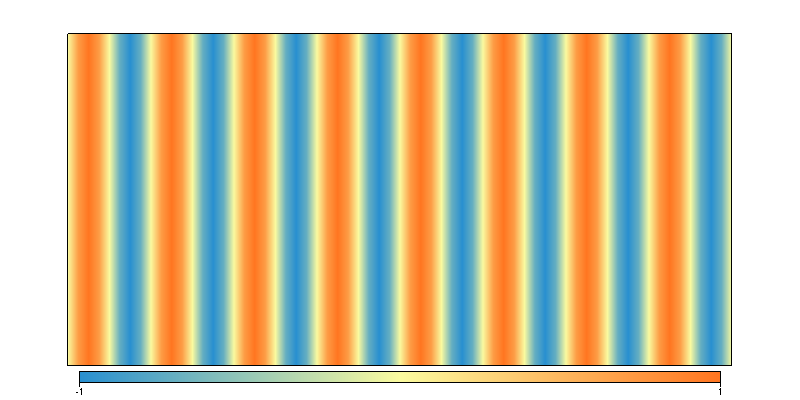

In [19]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
fn_input = fn.input()
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,64), maxCoord=(2.,1.))

# Create sinusoidal function in the horizontal direction.
# Note that the square brackets operator is overloaded to extract 
# a certain axis' value from vector functions.
fn_sin = fn.math.sin(8.*np.pi*fn_input[0])
# take a look
fig = glucifer.Figure(figsize=(800,400))
fig.append(glucifer.objects.Surface(mesh,fn_sin))
fig.show()

We also provide an alias to this class in `function.coord`. This is strictly a Python alias, and is identical in all ways (except name!) to `function.input`. It is provided because we often use the `input` function to operate on coordinate values (as above), but it is worth noting that function inputs are certainly not restricted to coordinates or vectors, and in these cases it would be misleading to use the `coord` function. 

## Branching Functions

Branching functions are functions which nest other functions, and select which function to execute based on some condition (also expressed as a function!). The most common use case for branching functions are for defining *materials* within your model which exhibit different behaviours (based on their associated function). Note that Underworld2 does not include an explict 'material' construct (unlike Underworld1), however the equivalent functionality may be obtained through branching functions.

Two branching functions are currently provided:

`function.branching.map`: Key/value type mapping of behavior.<br/> 
`function.branching.conditional`: if/elif type behaviour.<br/> 

Refer to respective API documentation for further information on these function classes. The `map` function is usually used to construct material type behaviours. Note that the `map` function provides a subset of the `conditional` function behaviour, though it has performance advantages.

Let us construct a basic model with material type behaviours:


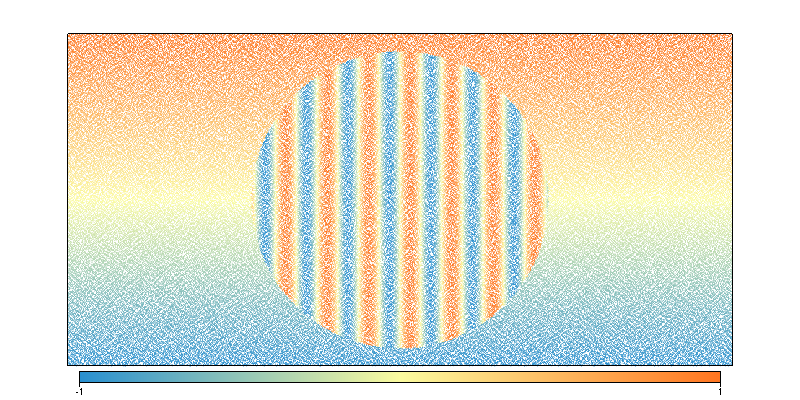

In [20]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(64,32),minCoord=(-2.0, -1.0), maxCoord=(2.0, 1.0))
swarm = uw.swarm.Swarm(mesh)
swarm.populate_using_layout(uw.swarm.layouts.PerCellSpaceFillerLayout(swarm,80))

# add a variable which will act as the key function for the map function.
material_index = swarm.add_variable("int",1)

# add the following for convenience and clarity.
outside_circle = 0
inside_circle = 1

# initialise material_index to be outside_circle everywhere
material_index.data[:] = outside_circle
# now set to inside_circle where inside circle!
r2 = 0.8
for index, position in enumerate(swarm.particleCoordinates.data):
    if position[0]**2 + position[1]**2 < r2:
        material_index.data[index] = inside_circle

# create mapped behaviour dictionary
fn_z = fn.input()[1]
fn_sin = fn.math.sin(8.*np.pi*fn.input()[0])
map_dict = { outside_circle:fn_z,
              inside_circle:fn_sin }
# create function
fn_map = fn.branching.map( fn_key = material_index, 
                          mapping = map_dict )

# viz
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Points(swarm,fn_map, pointSize=1.5) )
fig.show()

Alternatively, we can achieve an identical result using the `conditional` function, and its `evaluate()` method:

In [21]:
# note that the previous cell needs to be executed before this.
# the 'position' variable (created above) retains a reference to the 
# particleCoordinates numpy array. this inteferes with adding a new
# swarm variable, so we must delete it. 
del position  

# add a new variable first (we will test later for equality)
material_index2 = swarm.add_variable("int",1)

# first define a function which returns true if inside the circle
coord = fn.input()
fn_in_circle = fn.math.dot(coord,coord) < r2  # note the overload of the '<' operator

# now create the conditional 
fn_conditional = fn.branching.conditional(  ( (fn_in_circle,  inside_circle),
                                              (        True, outside_circle)   ) )

# use the evaluate, writing the results out to the material_index2 
material_index2.data[:] = fn_conditional.evaluate(swarm)
# check to ensure that we have identical results
if not (material_index2.data == material_index.data).all():
    raise RuntimeError("Error! These arrays should have identical values.")